In [1]:
%matplotlib inline
# packages to load 
# Check the versions of libraries
# Python version
import warnings
warnings.filterwarnings('ignore')
import sys
print('Python: {}'.format(sys.version))

import scipy
print('scipy: {}'.format(scipy.__version__))

import csv
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

# Importing metrics for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
import random as rn
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from keras import initializers
from keras.callbacks import (TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)

import math
from itertools import product
TRAIN_FILE_PATH = "data/X_train.csv"
TARGET_FILE_PATH =  "data/y_train.csv"
TEST_FILE_PATH = "data/X_test.csv"

seed=42
np.random.seed(seed)
rn.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)



# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)



Python: 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
scipy: 1.1.0


Using TensorFlow backend.


In [2]:
#Load train and test set

train_data = pd.read_csv(TRAIN_FILE_PATH)
train_data.drop("id", axis=1, inplace=True)

Y_train = pd.read_csv(TARGET_FILE_PATH)
Y_train.drop("id", axis=1, inplace = True)

test_data =  pd.read_csv(TEST_FILE_PATH)
id_test = test_data.columns[0]
test_data.drop("id", axis=1, inplace=True)

In [3]:
## ================ FUNCTION DEFS ================ ##

#Zero mean unit variance for train and test data
def scale_data(train, test):
    
    print("Train shape: ", train.shape)
    print("Test shape: ",test.shape)
    
    scaler = StandardScaler().fit(train, Y_train)
    train = scaler.transform(train)
    test = scaler.transform(test)
   
    return train, test

def make_submission(filename, predictions):
    test_data =  pd.read_csv(TEST_FILE_PATH)
    test_data["y"] = predictions
    test_data[["id", "y"]].to_csv("submissions/"+filename, index= False)
    
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

@as_keras_metric
def bmac_metric(Y_true, Y_pred):
    return tf.metrics.mean_per_class_accuracy(Y_true, Y_pred, 3)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# define baseline model
def baseline_model(weights=[], dropout=0.5, lambda_reg=2.0):
    # create model
    optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #model.add(LeakyReLU(alpha=0.1))
    # model.add(Dropout(rate = dropout))

    #model.add(Dense(1, kernel_regularizer = regularizers.l1(lambda_reg)))
    
    
    nn = Sequential()
    
    nn.add(Dense(32, input_dim=1000, activation='relu', kernel_regularizer = regularizers.l2(lambda_reg)))
    #nn.add(LeakyReLU(alpha=0.1))
    #nn.add(Dropout(rate = dropout))
    
    nn.add(Dense(16, activation='relu'))
    #nn.add(LeakyReLU(alpha=0.1))
    #nn.add(Dropout(rate = dropout))
    
    nn.add(Dense(8, activation='relu'))
    #nn.add(LeakyReLU(alpha=0.1))
    #nn.add(Dropout(rate = dropout))
    
    nn.add(Dense(4,activation='relu'))
    #nn.add(LeakyReLU(alpha=0.1))
    #nn.add(Dropout(rate = dropout))
    
    nn.add(Dense(3, activation='softmax'))
    # Compile model
   

    nn.compile(loss="categorical_crossentropy", #weighted_categorical_crossentropy(weights), 
               optimizer=optimizer, 
               metrics=[bmac_metric])
    nn.summary()
    return nn
    

In [4]:
X_train_scaled, X_test_scaled = scale_data(train_data, test_data)
# encode class values as integers
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(Y_train.values)
encoded_Y = encoder.transform(Y_train.values).toarray()

Train shape:  (4800, 1000)
Test shape:  (4100, 1000)


In [9]:
clf = svm.SVC(
        class_weight={0: 6, 1: 1, 2: 6},
        decision_function_shape='ovr',
        kernel='rbf'
    )
clf.fit(train_data.values, Y_train.values)
    
predicted = clf.predict(test_data.values)
make_submission('ax_SVC_ovr_rbf.csv', predicted)

/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [22]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
BMAC = []

for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = train_data.values[train]
    Y = Y_train.values[train]
    X_test = train_data.values[test]
    Y_valid = Y_train.values[test]
    
    clf = svm.SVC(
        class_weight={0: 6, 1: 1, 2: 6}
    )
    clf.fit(X, Y)
    
    Y_pred = clf.predict(X_test)
    Y_true = Y_train.values[test]
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    print(f"Current BMAC score {cur_BMAC}")
    BMAC.append(cur_BMAC)

print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))

#predicted= clf.predict(X_test_scaled)
#make_submission('ax_SVC_scaled.csv', predicted)

(4320, 1000)
(4320, 1)
Current BMAC score 0.6611111111111111
(4320, 1000)
(4320, 1)
Current BMAC score 0.6861111111111112
(4320, 1000)
(4320, 1)
Current BMAC score 0.7064814814814815
(4320, 1000)
(4320, 1)
Current BMAC score 0.6953703703703704
(4320, 1000)
(4320, 1)
Current BMAC score 0.7259259259259259
(4320, 1000)
(4320, 1)
Current BMAC score 0.7157407407407407
(4320, 1000)
(4320, 1)
Current BMAC score 0.686111111111111
(4320, 1000)
(4320, 1)
Current BMAC score 0.6972222222222223
(4320, 1000)
(4320, 1)
Current BMAC score 0.7268518518518517
(4320, 1000)
(4320, 1)
Current BMAC score 0.6351851851851852
AVG: BMAC score: 0.6936 (+/- 0.0272)


# Softmax

/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


540
3240
540
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                32032     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 15        
Total params: 32,747
Trainable params: 32,747
Non-trainable params: 0
_________________________________________________________________
Train on 4320 samples, validate on 480 samples
Epoch 1/70
100/100 [==============================] - 2s 24ms/step - loss: 8.3

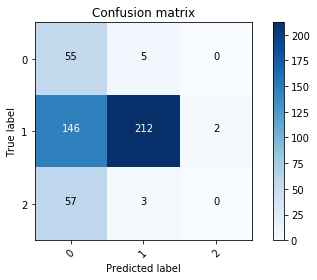

In [5]:
BMAC = []
cMat = None

# tf board call back
tbCallBack = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
earlyStop = EarlyStopping(monitor='val_bmac_metric', patience=10, verbose=1, mode='auto')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_bmac_metric', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_bmac_metric', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='max')

num_epochs = 70

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = encoded_Y[train]
    X_test = X_train_scaled[test]
    Y_valid = encoded_Y[test]
    # compute the class weights
    fac_0_2_class = 2
    #class_weights = np.array([(np.sum(Y_train.values == 0) / X_train_scaled.shape[0]) * fac_0_2_class, 
    #                      np.sum(Y_train.values == 1) / X_train_scaled.shape[0], 
    #                      (np.sum(Y_train.values == 2) / X_train_scaled.shape[0]) * fac_0_2_class])
    print(np.sum(Y_train.values[train] == 0))
    print(np.sum(Y_train.values[train] == 1))
    print(np.sum(Y_train.values[train] == 2))
    model = baseline_model()
    class_weight = {0: 6., 1: 1.,2: 6.}
    
    # Fit the model
    model.fit(x=X, y=Y, epochs=num_epochs, verbose=1, validation_data=(X_test, Y_valid), shuffle=True, 
              steps_per_epoch=100, initial_epoch=0, validation_steps=5,
              class_weight=class_weight,
             callbacks=[
             #tbCallBack,
             #earlyStop, 
             mcp_save, 
             reduce_lr_loss])
    
    
    
    model.load_weights(filepath = '.mdl_wts.hdf5')
    Y_pred = [[p] for p in  model.predict_classes(X_test)]
    Y_true = Y_train.values[test]
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    print(f"Current BMAC score {cur_BMAC}")
    BMAC.append(cur_BMAC)
    cMat = confusion_matrix(Y_true, Y_pred)
    break # only do a single run
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
plot_confusion_matrix(cMat, ["0", "1", "2"])


In [38]:
# use all data for training
fac_0_2_class = 1
num_epochs = 100
class_weights = np.array([(np.sum(Y_train.values == 0) / X_train_scaled.shape[0]) * fac_0_2_class, 
                          np.sum(Y_train.values == 1) / X_train_scaled.shape[0], 
                          (np.sum(Y_train.values == 2) / X_train_scaled.shape[0]) * fac_0_2_class])

model = baseline_model(class_weights)


# Fit the model
model.fit(x=X_train_scaled, y=encoded_Y, epochs=num_epochs, verbose=1, validation_split=0.1, shuffle=True, 
          steps_per_epoch=100, initial_epoch=0, validation_steps=5, 
         callbacks=[
             tbCallBack,
             #earlyStop, 
             mcp_save, 
             reduce_lr_loss])

model.load_weights(filepath = '.mdl_wts.hdf5')
pred = model.predict_classes(X_test_scaled)
make_submission('ax_SOFTMAX.csv', pred)
print("Process finsihed!")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 32)                32032     
_________________________________________________________________
dense_122 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_123 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_124 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_125 (Dense)            (None, 3)                 15        
Total params: 32,747
Trainable params: 32,747
Non-trainable params: 0
_________________________________________________________________
Train on 4320 samples, validate on 480 samples


KeyboardInterrupt: 